Training on balanced dataset, testing on imbalanced dataset...
Epoch 1/20 | Train Loss: 135.9173 | Val Loss: 16.0620 | Train Acc: 0.0625 | Val Acc: 0.0000
Epoch 2/20 | Train Loss: 133.2426 | Val Loss: 14.7620 | Train Acc: 0.0625 | Val Acc: 0.0000
Epoch 3/20 | Train Loss: 130.1293 | Val Loss: 13.0583 | Train Acc: 0.0625 | Val Acc: 0.0000
Epoch 4/20 | Train Loss: 125.9756 | Val Loss: 10.8744 | Train Acc: 0.0625 | Val Acc: 0.0000
Epoch 5/20 | Train Loss: 120.5111 | Val Loss: 8.2110 | Train Acc: 0.0625 | Val Acc: 0.0000
Epoch 6/20 | Train Loss: 112.5486 | Val Loss: 5.3080 | Train Acc: 0.0000 | Val Acc: 0.0000
Epoch 7/20 | Train Loss: 101.2467 | Val Loss: 2.6087 | Train Acc: 0.0000 | Val Acc: 0.5000
Epoch 8/20 | Train Loss: 91.4108 | Val Loss: 1.0372 | Train Acc: 0.0000 | Val Acc: 0.0000
Epoch 9/20 | Train Loss: 82.1992 | Val Loss: 1.9678 | Train Acc: 0.0000 | Val Acc: 0.5000
Epoch 10/20 | Train Loss: 63.2311 | Val Loss: 7.5232 | Train Acc: 0.0000 | Val Acc: 0.0000
Epoch 11/20 | Train Loss:

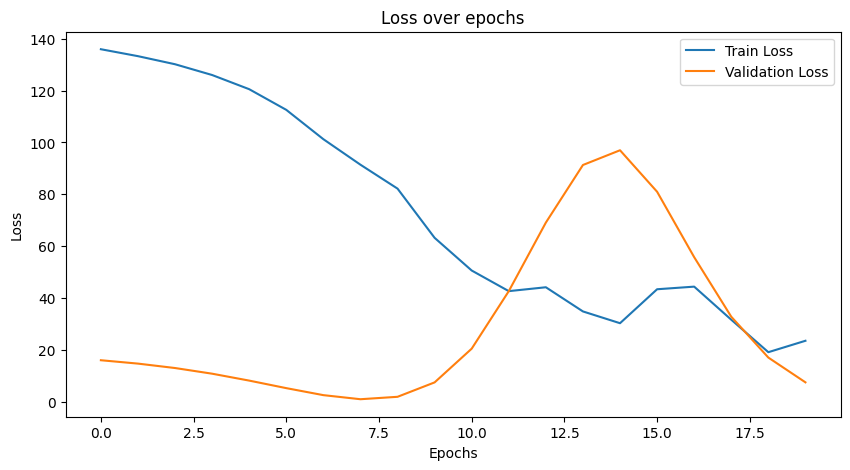

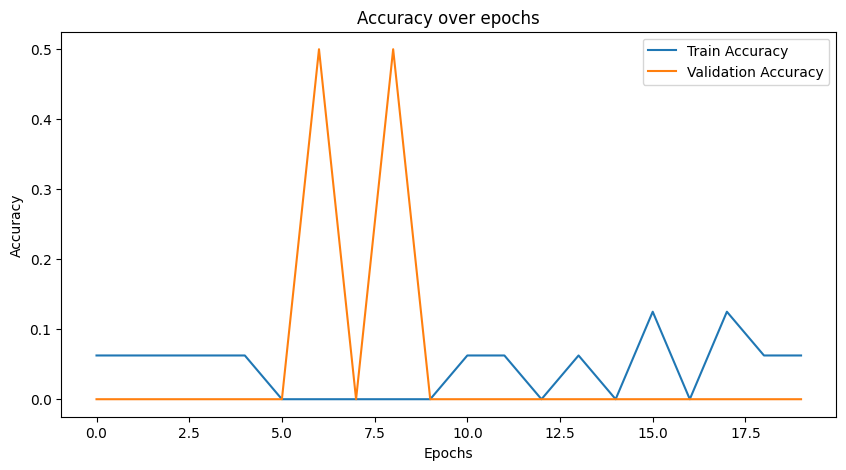

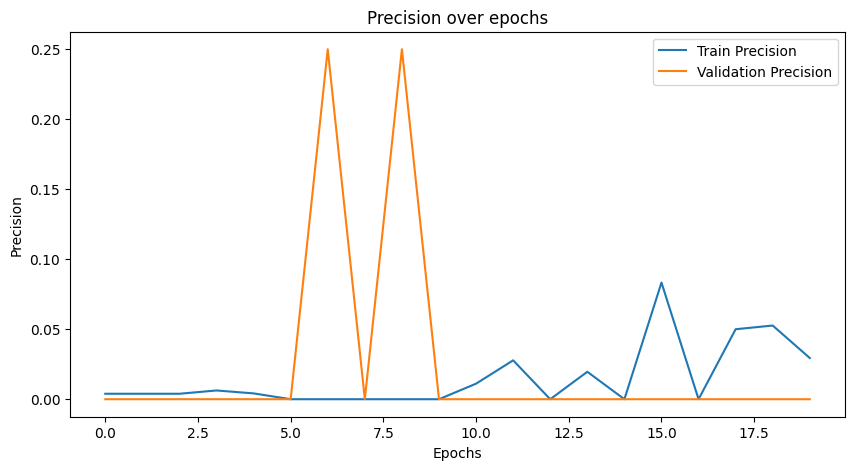

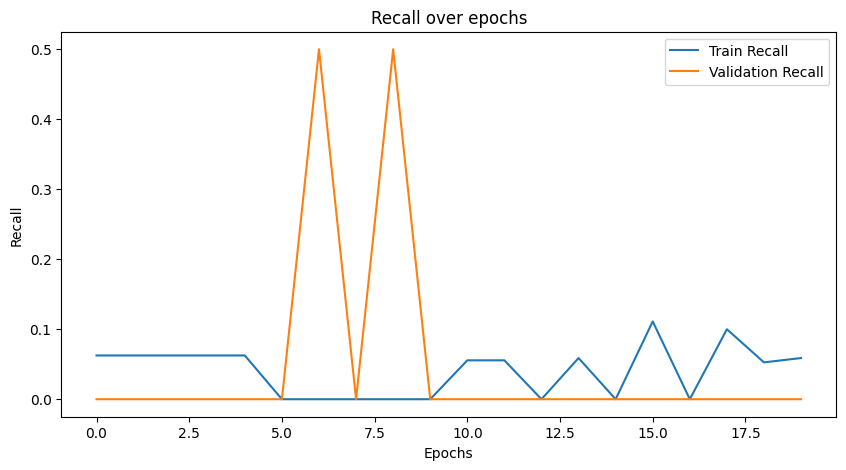

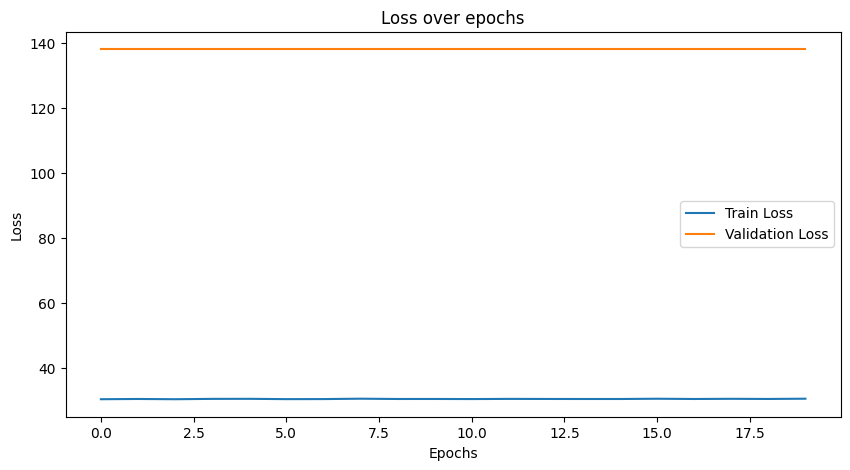

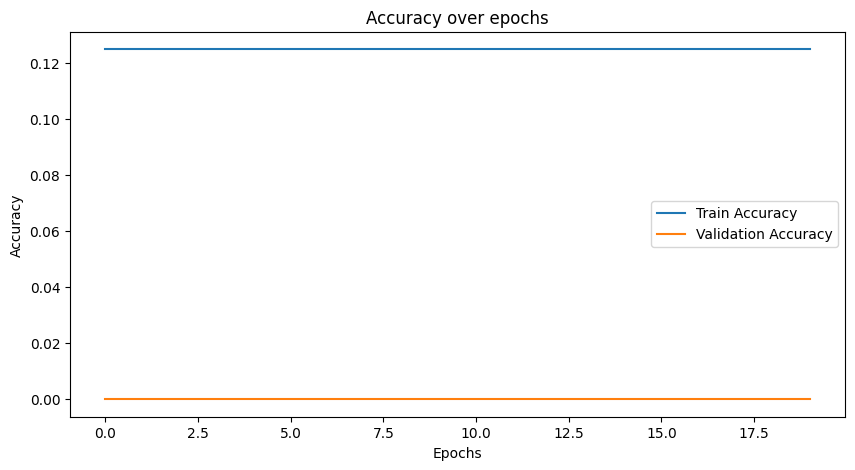

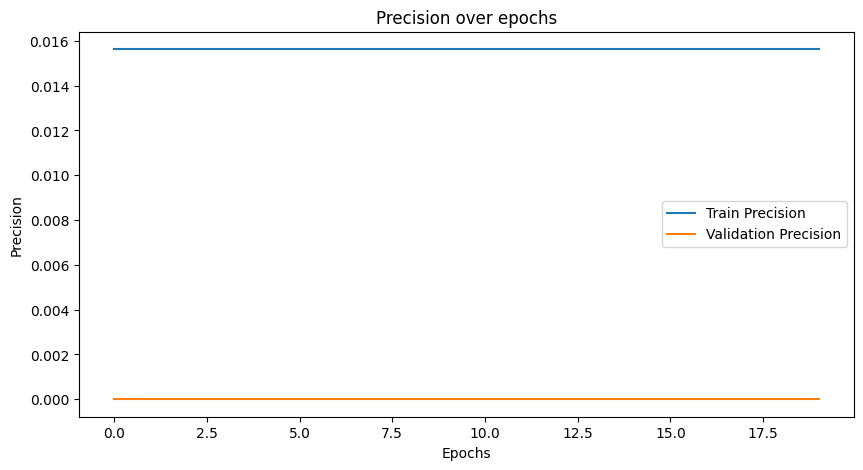

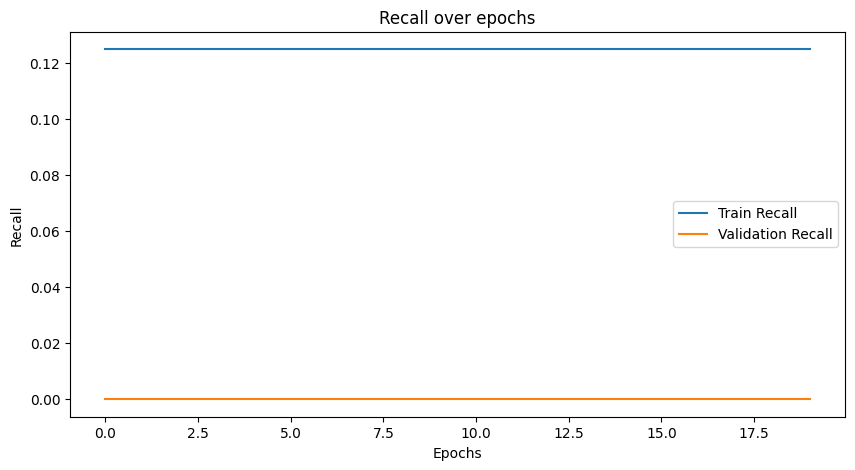

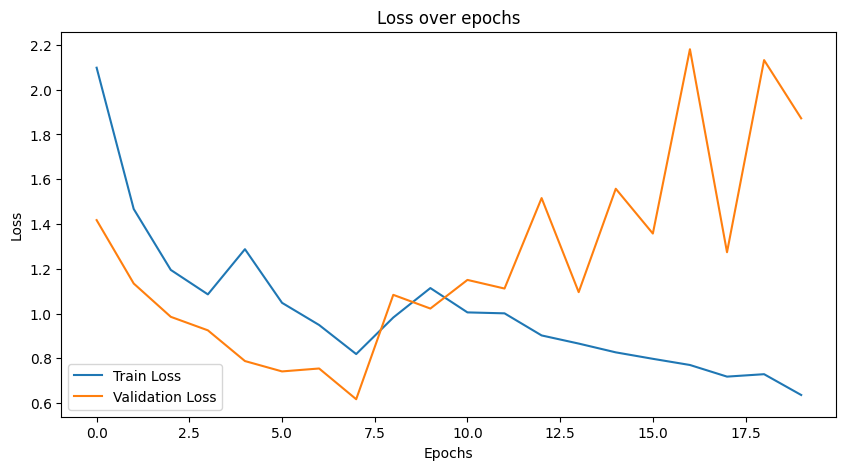

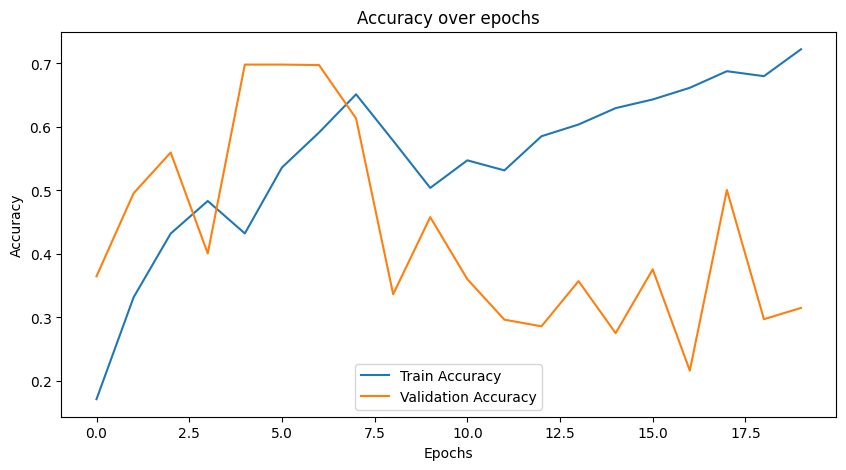

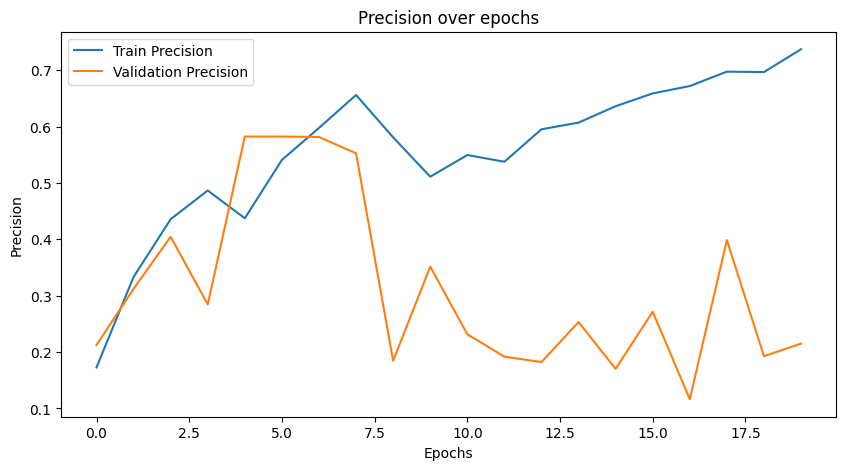

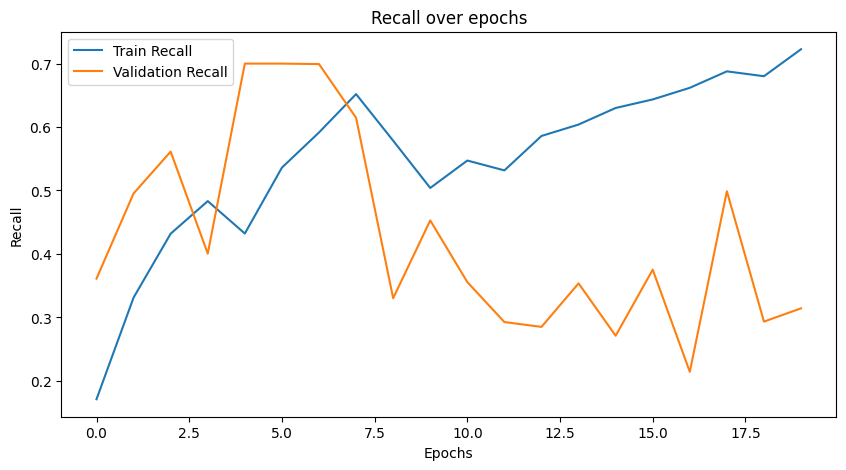

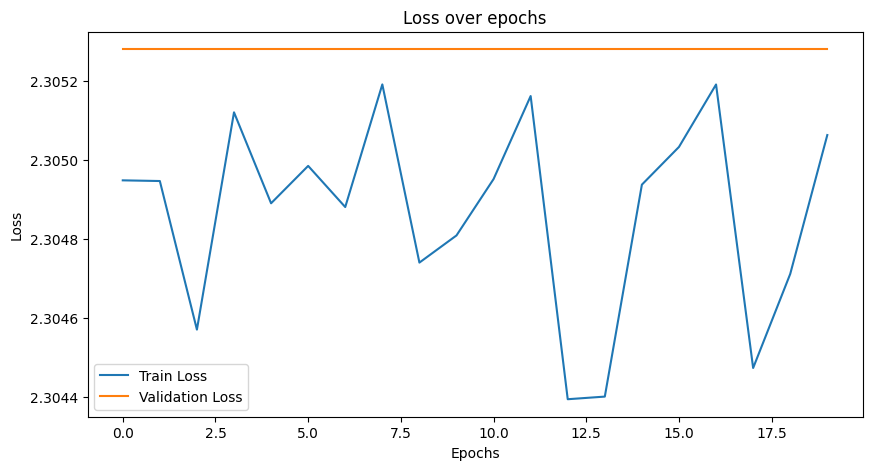

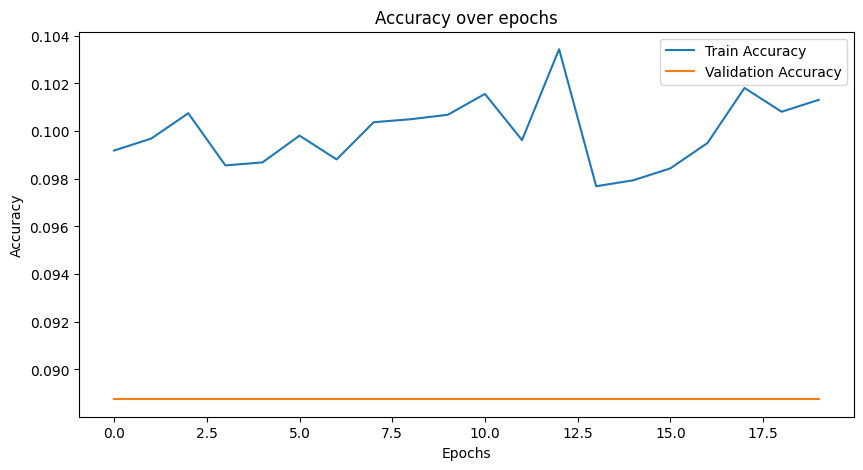

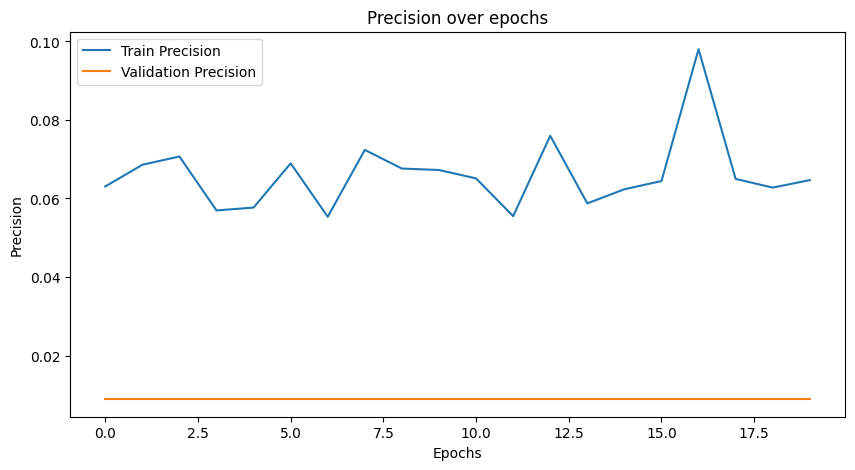

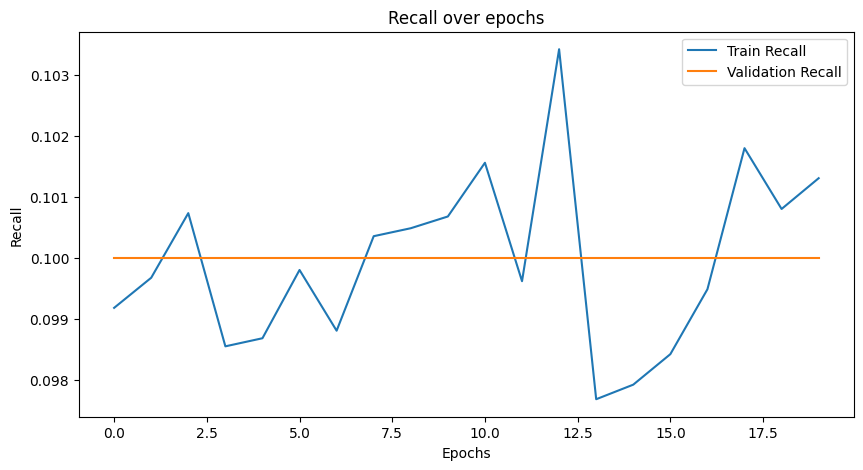

In [ ]:
import torch
import torchvision
import numpy as np
import os
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision import transforms
import random
import copy
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score
import json
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

os.makedirs('./Dataset/', exist_ok=True)

# PART A: 8-Puzzle Dataset Generation
mnist_train = torchvision.datasets.MNIST(
    root='./Dataset/',
    train=True,
    download=True,
    transform=None
)

mnist_test = torchvision.datasets.MNIST(
    root='./Dataset/',
    train=False,
    download=True,
    transform=None
)

targets = mnist_train.targets.numpy()
classes, class_counts = np.unique(targets, return_counts=True)
num_classes = len(classes)

samples_per_class = 1000
balanced_indices = []

for class_idx in range(num_classes):
    class_indices = np.where(targets == class_idx)[0]
    selected_indices = class_indices[:samples_per_class]
    balanced_indices.extend(selected_indices)

random.shuffle(balanced_indices)
balanced_subset = Subset(mnist_train, balanced_indices)

imbalanced_indices = []
imbal_class_counts = [1000, 1000, 1000, 1000, 1000, 500, 500, 500, 500, 500]

for class_idx in range(num_classes):
    class_indices = np.where(targets == class_idx)[0]
    selected_indices = class_indices[:imbal_class_counts[class_idx]]
    imbalanced_indices.extend(selected_indices)

random.shuffle(imbalanced_indices)
imbalanced_subset = Subset(mnist_train, imbalanced_indices)

torch.save(balanced_subset, './Dataset/mnist_balanced.pt')
torch.save(imbalanced_subset, './Dataset/mnist_imbalanced.pt')

basic_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

augmented_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(30),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.Normalize((0.5,), (0.5,))
])

class TransformedSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, idx):
        x, y = self.subset[idx]

        # Convert tensor to PIL Image if needed before applying transforms
        if isinstance(x, torch.Tensor) and self.transform is not None:
            # Convert tensor to PIL Image
            x = transforms.ToPILImage()(x)

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.subset)

# Add TransformedSubset to safe globals
try:
    torch.serialization.add_safe_globals([TransformedSubset])
except Exception as e:
    print(f"Failed to add safe globals: {e}")

balanced_basic = TransformedSubset(balanced_subset, basic_transform)
balanced_augmented = TransformedSubset(balanced_subset, augmented_transform)
imbalanced_basic = TransformedSubset(imbalanced_subset, basic_transform)
imbalanced_augmented = TransformedSubset(imbalanced_subset, augmented_transform)

torch.save(balanced_basic, './Dataset/mnist_balanced_basic.pt')
torch.save(balanced_augmented, './Dataset/mnist_balanced_augmented.pt')
torch.save(imbalanced_basic, './Dataset/mnist_imbalanced_basic.pt')
torch.save(imbalanced_augmented, './Dataset/mnist_imbalanced_augmented.pt')

class EightPuzzleDataset(Dataset):
    def __init__(self, num_samples=20000, transform=None):
        self.transform = transform
        self.data = []
        self.targets = []
        self._generate_puzzle_states(num_samples)

    def _generate_puzzle_states(self, num_samples):
        goal_state = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 0]])

        for _ in range(num_samples):
            current_state = copy.deepcopy(goal_state)
            num_moves = random.randint(5, 50)

            for _ in range(num_moves):
                zero_pos = np.where(current_state == 0)
                x, y = zero_pos[0][0], zero_pos[1][0]

                moves = []
                if x > 0: moves.append((-1, 0))
                if x < 2: moves.append((1, 0))
                if y > 0: moves.append((0, -1))
                if y < 2: moves.append((0, 1))

                dx, dy = random.choice(moves)
                new_x, new_y = x + dx, y + dy

                current_state[x, y], current_state[new_x, new_y] = current_state[new_x, new_y], current_state[x, y]

            manhattan_dist = 0
            for i in range(3):
                for j in range(3):
                    if current_state[i, j] != 0:
                        goal_pos = np.where(goal_state == current_state[i, j])
                        goal_x, goal_y = goal_pos[0][0], goal_pos[1][0]
                        manhattan_dist += abs(i - goal_x) + abs(j - goal_y)

            puzzle_image = np.zeros((28, 28), dtype=np.uint8)
            for i in range(3):
                for j in range(3):
                    start_x, start_y = i*9, j*9
                    value = current_state[i, j]
                    if value != 0:
                        puzzle_image[start_x:start_x+9, start_y:start_y+9] = value * 25

            self.data.append(torch.tensor(puzzle_image, dtype=torch.uint8))
            self.targets.append(manhattan_dist)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        target = self.targets[idx]

        if self.transform:
            # Convert tensor to PIL Image if needed
            if isinstance(image, torch.Tensor):
                image = transforms.ToPILImage()(image)
            image = self.transform(image)

        return image, target

# Add EightPuzzleDataset to safe globals
try:
    torch.serialization.add_safe_globals([EightPuzzleDataset])
except Exception as e:
    print(f"Failed to add safe globals: {e}")

puzzle_dataset = EightPuzzleDataset(num_samples=20000)

targets = np.array([t for _, t in puzzle_dataset])
unique_targets, target_counts = np.unique(targets, return_counts=True)

balanced_puzzle_indices = []
samples_per_distance = min(target_counts)

for target_val in unique_targets:
    target_indices = np.where(targets == target_val)[0]
    selected_indices = target_indices[:samples_per_distance]
    balanced_puzzle_indices.extend(selected_indices)

random.shuffle(balanced_puzzle_indices)
balanced_puzzle_subset = Subset(puzzle_dataset, balanced_puzzle_indices)

imbalanced_puzzle_indices = []
for i, target_val in enumerate(unique_targets):
    target_indices = np.where(targets == target_val)[0]
    if i < len(unique_targets) // 2:
        selected_indices = target_indices[:samples_per_distance]
    else:
        selected_indices = target_indices[:samples_per_distance // 2]
    imbalanced_puzzle_indices.extend(selected_indices)

random.shuffle(imbalanced_puzzle_indices)
imbalanced_puzzle_subset = Subset(puzzle_dataset, imbalanced_puzzle_indices)

puzzle_basic_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

puzzle_augmented_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(15),
    transforms.Normalize((0.5,), (0.5,))
])

balanced_puzzle_basic = TransformedSubset(balanced_puzzle_subset, puzzle_basic_transform)
balanced_puzzle_augmented = TransformedSubset(balanced_puzzle_subset, puzzle_augmented_transform)
imbalanced_puzzle_basic = TransformedSubset(imbalanced_puzzle_subset, puzzle_basic_transform)
imbalanced_puzzle_augmented = TransformedSubset(imbalanced_puzzle_subset, puzzle_augmented_transform)

torch.save(balanced_puzzle_basic, './Dataset/puzzle_balanced_basic.pt')
torch.save(balanced_puzzle_augmented, './Dataset/puzzle_balanced_augmented.pt')
torch.save(imbalanced_puzzle_basic, './Dataset/puzzle_imbalanced_basic.pt')
torch.save(imbalanced_puzzle_augmented, './Dataset/puzzle_imbalanced_augmented.pt')

# PART B: Phone Number Dataset Generation
class PhoneNumberDataset(Dataset):
    def __init__(self, num_samples=20000, transform=None):
        self.transform = transform
        self.data = []
        self.targets = []
        self.country_codes = {
            'US': '1',
            'UK': '44',
            'India': '91',
            'China': '86',
            'Brazil': '55',
            'Australia': '61',
            'Germany': '49',
            'Japan': '81',
            'Canada': '1',
            'France': '33'
        }
        self._generate_phone_numbers(num_samples)

    def _generate_phone_numbers(self, num_samples):
        for i in range(num_samples):
            phone_number = self._generate_valid_phone_number()
            phone_image = self._create_phone_number_image(phone_number)
            phone_tensor = torch.tensor(np.array(phone_image), dtype=torch.uint8)
            country_idx = i % 10
            self.data.append(phone_tensor)
            self.targets.append(country_idx)

    def _generate_valid_phone_number(self):
        while True:
            digits = [str(random.randint(0, 9)) for _ in range(10)]
            if max([digits.count(d) for d in set(digits)]) <= 4:
                return ''.join(digits)

    def _create_phone_number_image(self, phone_number):
        img = Image.new('L', (280, 28), color=255)
        draw = ImageDraw.Draw(img)
        try:
            font = ImageFont.truetype("DejaVuSansMono.ttf", 20)
        except IOError:
            font = ImageFont.load_default()
        draw.text((10, 4), phone_number, fill=0, font=font)
        return img

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        target = self.targets[idx]

        if self.transform:
            # Convert tensor to PIL Image if needed
            if isinstance(image, torch.Tensor):
                image = transforms.ToPILImage()(image)
            image = self.transform(image)

        return image, target

# Add PhoneNumberDataset to safe globals
try:
    torch.serialization.add_safe_globals([PhoneNumberDataset])
except Exception as e:
    print(f"Failed to add safe globals: {e}")

phone_dataset = PhoneNumberDataset(num_samples=20000)

targets = np.array([t for _, t in phone_dataset])
unique_targets, target_counts = np.unique(targets, return_counts=True)
balanced_indices = []
samples_per_country = min(target_counts)
for target_val in unique_targets:
    target_indices = np.where(targets == target_val)[0]
    selected_indices = target_indices[:samples_per_country]
    balanced_indices.extend(selected_indices)
random.shuffle(balanced_indices)
balanced_phone_subset = Subset(phone_dataset, balanced_indices)

imbalanced_indices = []
digit_patterns = {}
for idx, (img, _) in enumerate(phone_dataset):
    if isinstance(img, torch.Tensor):
        img_np = img.numpy()
    else:
        img_np = np.array(img)
    digit_counts = {}
    for i in range(10):
        digit_counts[str(i)] = 0
    for i in range(10):
        digit = str(i)
        if digit in digit_counts and digit_counts[digit] < 4:
            digit_counts[digit] += 1
    pattern = tuple(sorted([(d, c) for d, c in digit_counts.items() if c >= 3]))
    if pattern:
        if pattern not in digit_patterns:
            digit_patterns[pattern] = []
        digit_patterns[pattern].append(idx)
for pattern, indices in digit_patterns.items():
    imbalanced_indices.extend(indices[:min(len(indices), 50)])
while len(imbalanced_indices) < len(balanced_indices):
    idx = random.randint(0, len(phone_dataset)-1)
    if idx not in imbalanced_indices:
        imbalanced_indices.append(idx)
random.shuffle(imbalanced_indices)
imbalanced_phone_subset = Subset(phone_dataset, imbalanced_indices[:len(balanced_indices)])

phone_basic_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

class CountryCodeTransform(Dataset):
    def __init__(self, subset, country_codes, transform=None):
        self.subset = subset
        self.transform = transform
        self.country_codes = country_codes
    def __getitem__(self, idx):
        image, target = self.subset[idx]
        if isinstance(image, torch.Tensor):
            image = transforms.ToPILImage()(image)
        country = list(self.country_codes.keys())[target]
        code = self.country_codes[country]
        new_img = Image.new('L', (image.width + 30, image.height), color=255)
        new_img.paste(image, (30, 0))
        draw = ImageDraw.Draw(new_img)
        try:
            font = ImageFont.truetype("DejaVuSansMono.ttf", 20)
        except IOError:
            font = ImageFont.load_default()
        draw.text((5, 4), code, fill=0, font=font)
        if self.transform:
            new_img = self.transform(new_img)
        return new_img, target
    def __len__(self):
        return len(self.subset)

# Add CountryCodeTransform to safe globals
try:
    torch.serialization.add_safe_globals([CountryCodeTransform])
except Exception as e:
    print(f"Failed to add safe globals: {e}")

balanced_phone_basic = CountryCodeTransform(
    balanced_phone_subset,
    phone_dataset.country_codes,
    phone_basic_transform
)

imbalanced_phone_basic = CountryCodeTransform(
    imbalanced_phone_subset,
    phone_dataset.country_codes,
    phone_basic_transform
)

torch.save(balanced_phone_basic, './Dataset/phone_balanced_basic.pt')
torch.save(imbalanced_phone_basic, './Dataset/phone_imbalanced_basic.pt')

# PART C: 8-Puzzle Neural Network Implementation
class PuzzleMLP(nn.Module):
    def __init__(self, config):
        super(PuzzleMLP, self).__init__()

        input_size = config.get("input_size", 28 * 28)
        hidden_layers = config.get("hidden_layers", [256, 128])
        output_size = config.get("output_size", 1)
        dropout_rate = config.get("dropout_rate", 0.2)

        layers = []

        layers.append(nn.Linear(input_size, hidden_layers[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))

        for i in range(len(hidden_layers) - 1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))

        layers.append(nn.Linear(hidden_layers[-1], output_size))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

def get_puzzle_dataloaders(config):
    batch_size = config["batch_size"]
    data_path = config["data_path"]

    # Use weights_only=False to avoid unpickling errors
    balanced_data = torch.load(os.path.join(data_path, "puzzle_balanced_basic.pt"), weights_only=False)
    imbalanced_data = torch.load(os.path.join(data_path, "puzzle_imbalanced_basic.pt"), weights_only=False)

    balanced_size = len(balanced_data)
    imbalanced_size = len(imbalanced_data)

    balanced_train_size = int(0.8 * balanced_size)
    imbalanced_train_size = int(0.8 * imbalanced_size)

    balanced_indices = list(range(balanced_size))
    imbalanced_indices = list(range(imbalanced_size))

    random.shuffle(balanced_indices)
    random.shuffle(imbalanced_indices)

    balanced_train_indices = balanced_indices[:balanced_train_size]
    balanced_test_indices = balanced_indices[balanced_train_size:]

    imbalanced_train_indices = imbalanced_indices[:imbalanced_train_size]
    imbalanced_test_indices = imbalanced_indices[imbalanced_train_size:]

    balanced_train = Subset(balanced_data, balanced_train_indices)
    balanced_test = Subset(balanced_data, balanced_test_indices)

    imbalanced_train = Subset(imbalanced_data, imbalanced_train_indices)
    imbalanced_test = Subset(imbalanced_data, imbalanced_test_indices)

    balanced_train_loader = DataLoader(
        balanced_train,
        batch_size=batch_size,
        shuffle=True,
        num_workers=config.get("num_workers", 2)
    )

    balanced_test_loader = DataLoader(
        balanced_test,
        batch_size=batch_size,
        shuffle=False,
        num_workers=config.get("num_workers", 2)
    )

    imbalanced_train_loader = DataLoader(
        imbalanced_train,
        batch_size=batch_size,
        shuffle=True,
        num_workers=config.get("num_workers", 2)
    )

    imbalanced_test_loader = DataLoader(
        imbalanced_test,
        batch_size=batch_size,
        shuffle=False,
        num_workers=config.get("num_workers", 2)
    )

    return {
        "balanced_train": balanced_train_loader,
        "balanced_test": balanced_test_loader,
        "imbalanced_train": imbalanced_train_loader,
        "imbalanced_test": imbalanced_test_loader
    }

class PuzzleTrainer:
    def __init__(self, config):
        self.config = config
        self.model = PuzzleMLP(config.get("model", {}))

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.model.to(self.device)

        self.learning_rate = config.get("training", {}).get("learning_rate", 0.001)
        self.epochs = config.get("training", {}).get("epochs", 10)

        optimizer_name = config.get("training", {}).get("optimizer", "adam")
        if optimizer_name.lower() == "adam":
            self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        elif optimizer_name.lower() == "sgd":
            self.optimizer = optim.SGD(self.model.parameters(), lr=self.learning_rate)
        else:
            self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

        self.criterion = nn.MSELoss()

        self.dataloaders = get_puzzle_dataloaders(config)

        self.metrics = {
            "train_loss": [],
            "val_loss": [],
            "train_accuracy": [],
            "val_accuracy": [],
            "train_precision": [],
            "val_precision": [],
            "train_recall": [],
            "val_recall": []
        }

    def train(self, train_loader, val_loader):
        for epoch in range(self.epochs):
            self.model.train()
            train_loss = 0.0
            train_preds = []
            train_targets = []

            for inputs, targets in train_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device).float()

                self.optimizer.zero_grad()

                outputs = self.model(inputs)
                loss = self.criterion(outputs.squeeze(), targets)

                loss.backward()
                self.optimizer.step()

                train_loss += loss.item() * inputs.size(0)

                train_preds.extend(outputs.squeeze().detach().cpu().numpy().round())
                train_targets.extend(targets.cpu().numpy())

            train_loss = train_loss / len(train_loader.dataset)

            train_accuracy = accuracy_score(train_targets, train_preds)
            train_precision = precision_score(train_targets, train_preds, average='macro', zero_division=0)
            train_recall = recall_score(train_targets, train_preds, average='macro', zero_division=0)

            self.model.eval()
            val_loss = 0.0
            val_preds = []
            val_targets = []

            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(self.device), targets.to(self.device).float()

                    outputs = self.model(inputs)
                    loss = self.criterion(outputs.squeeze(), targets)

                    val_loss += loss.item() * inputs.size(0)

                    val_preds.extend(outputs.squeeze().cpu().numpy().round())
                    val_targets.extend(targets.cpu().numpy())

            val_loss = val_loss / len(val_loader.dataset)

            val_accuracy = accuracy_score(val_targets, val_preds)
            val_precision = precision_score(val_targets, val_preds, average='macro', zero_division=0)
            val_recall = recall_score(val_targets, val_preds, average='macro', zero_division=0)

            self.metrics["train_loss"].append(train_loss)
            self.metrics["val_loss"].append(val_loss)
            self.metrics["train_accuracy"].append(train_accuracy)
            self.metrics["val_accuracy"].append(val_accuracy)
            self.metrics["train_precision"].append(train_precision)
            self.metrics["val_precision"].append(val_precision)
            self.metrics["train_recall"].append(train_recall)
            self.metrics["val_recall"].append(val_recall)

            print(f'Epoch {epoch+1}/{self.epochs} | '
                  f'Train Loss: {train_loss:.4f} | '
                  f'Val Loss: {val_loss:.4f} | '
                  f'Train Acc: {train_accuracy:.4f} | '
                  f'Val Acc: {val_accuracy:.4f}')

    def plot_metrics(self, save_dir="./results"):
        os.makedirs(save_dir, exist_ok=True)

        plt.figure(figsize=(10, 5))
        plt.plot(self.metrics["train_loss"], label="Train Loss")
        plt.plot(self.metrics["val_loss"], label="Validation Loss")
        plt.title("Loss over epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(os.path.join(save_dir, "loss.png"))

        plt.figure(figsize=(10, 5))
        plt.plot(self.metrics["train_accuracy"], label="Train Accuracy")
        plt.plot(self.metrics["val_accuracy"], label="Validation Accuracy")
        plt.title("Accuracy over epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.savefig(os.path.join(save_dir, "accuracy.png"))

        plt.figure(figsize=(10, 5))
        plt.plot(self.metrics["train_precision"], label="Train Precision")
        plt.plot(self.metrics["val_precision"], label="Validation Precision")
        plt.title("Precision over epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Precision")
        plt.legend()
        plt.savefig(os.path.join(save_dir, "precision.png"))

        plt.figure(figsize=(10, 5))
        plt.plot(self.metrics["train_recall"], label="Train Recall")
        plt.plot(self.metrics["val_recall"], label="Validation Recall")
        plt.title("Recall over epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Recall")
        plt.legend()
        plt.savefig(os.path.join(save_dir, "recall.png"))

    def run_experiment(self):
        print("Training on balanced dataset, testing on imbalanced dataset...")
        self.train(
            self.dataloaders["balanced_train"],
            self.dataloaders["imbalanced_test"]
        )
        self.plot_metrics("./results/balanced_to_imbalanced")

        self.metrics = {key: [] for key in self.metrics}
        self.model = PuzzleMLP(self.config.get("model", {}))
        self.model = self.model.to(self.device)

        print("Training on imbalanced dataset, testing on balanced dataset...")
        self.train(
            self.dataloaders["imbalanced_train"],
            self.dataloaders["balanced_test"]
        )
        self.plot_metrics("./results/imbalanced_to_balanced")

# PART D: Phone Number Neural Network Implementation
class PhoneNumberMLP(nn.Module):
    def __init__(self, config):
        super(PhoneNumberMLP, self).__init__()

        # Get the actual input size from a sample
        # For phone numbers, this will be larger than 784
        input_size = config.get("input_size", 28 * 310)  # Updated to match phone number image size
        hidden_layers = config.get("hidden_layers", [256, 128])
        output_size = config.get("output_size", 10)
        dropout_rate = config.get("dropout_rate", 0.2)

        layers = []

        layers.append(nn.Linear(input_size, hidden_layers[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))

        for i in range(len(hidden_layers) - 1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))

        layers.append(nn.Linear(hidden_layers[-1], output_size))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # Reshape input to (batch_size, -1) to flatten it
        x = x.view(x.size(0), -1)
        return self.model(x)

def get_phone_dataloaders(config):
    batch_size = config["batch_size"]
    data_path = config["data_path"]

    # Use weights_only=False to avoid unpickling errors
    balanced_data = torch.load(os.path.join(data_path, "phone_balanced_basic.pt"), weights_only=False)
    imbalanced_data = torch.load(os.path.join(data_path, "phone_imbalanced_basic.pt"), weights_only=False)

    balanced_size = len(balanced_data)
    imbalanced_size = len(imbalanced_data)

    balanced_train_size = int(0.8 * balanced_size)
    imbalanced_train_size = int(0.8 * imbalanced_size)

    balanced_indices = list(range(balanced_size))
    imbalanced_indices = list(range(imbalanced_size))

    random.shuffle(balanced_indices)
    random.shuffle(imbalanced_indices)

    balanced_train_indices = balanced_indices[:balanced_train_size]
    balanced_test_indices = balanced_indices[balanced_train_size:]

    imbalanced_train_indices = imbalanced_indices[:imbalanced_train_size]
    imbalanced_test_indices = imbalanced_indices[imbalanced_train_size:]

    balanced_train = Subset(balanced_data, balanced_train_indices)
    balanced_test = Subset(balanced_data, balanced_test_indices)

    imbalanced_train = Subset(imbalanced_data, imbalanced_train_indices)
    imbalanced_test = Subset(imbalanced_data, imbalanced_test_indices)

    balanced_train_loader = DataLoader(
        balanced_train,
        batch_size=batch_size,
        shuffle=True,
        num_workers=config.get("num_workers", 2)
    )

    balanced_test_loader = DataLoader(
        balanced_test,
        batch_size=batch_size,
        shuffle=False,
        num_workers=config.get("num_workers", 2)
    )

    imbalanced_train_loader = DataLoader(
        imbalanced_train,
        batch_size=batch_size,
        shuffle=True,
        num_workers=config.get("num_workers", 2)
    )

    imbalanced_test_loader = DataLoader(
        imbalanced_test,
        batch_size=batch_size,
        shuffle=False,
        num_workers=config.get("num_workers", 2)
    )

    return {
        "balanced_train": balanced_train_loader,
        "balanced_test": balanced_test_loader,
        "imbalanced_train": imbalanced_train_loader,
        "imbalanced_test": imbalanced_test_loader
    }

class PhoneNumberTrainer:
    def __init__(self, config):
        self.config = config
        self.model = PhoneNumberMLP(config.get("model", {}))

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.model.to(self.device)

        self.learning_rate = config.get("training", {}).get("learning_rate", 0.001)
        self.epochs = config.get("training", {}).get("epochs", 10)

        optimizer_name = config.get("training", {}).get("optimizer", "adam")
        if optimizer_name.lower() == "adam":
            self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        elif optimizer_name.lower() == "sgd":
            self.optimizer = optim.SGD(self.model.parameters(), lr=self.learning_rate)
        else:
            self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

        self.criterion = nn.CrossEntropyLoss()

        self.dataloaders = get_phone_dataloaders(config)

        self.metrics = {
            "train_loss": [],
            "val_loss": [],
            "train_accuracy": [],
            "val_accuracy": [],
            "train_precision": [],
            "val_precision": [],
            "train_recall": [],
            "val_recall": []
        }

    def train(self, train_loader, val_loader):
        for epoch in range(self.epochs):
            self.model.train()
            train_loss = 0.0
            train_preds = []
            train_targets = []

            for inputs, targets in train_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)

                self.optimizer.zero_grad()

                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)

                loss.backward()
                self.optimizer.step()

                train_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs, 1)
                train_preds.extend(predicted.cpu().numpy())
                train_targets.extend(targets.cpu().numpy())

            train_loss = train_loss / len(train_loader.dataset)

            train_accuracy = accuracy_score(train_targets, train_preds)
            train_precision = precision_score(train_targets, train_preds, average='macro', zero_division=0)
            train_recall = recall_score(train_targets, train_preds, average='macro', zero_division=0)

            self.model.eval()
            val_loss = 0.0
            val_preds = []
            val_targets = []

            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(self.device), targets.to(self.device)

                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, targets)

                    val_loss += loss.item() * inputs.size(0)

                    _, predicted = torch.max(outputs, 1)
                    val_preds.extend(predicted.cpu().numpy())
                    val_targets.extend(targets.cpu().numpy())

            val_loss = val_loss / len(val_loader.dataset)

            val_accuracy = accuracy_score(val_targets, val_preds)
            val_precision = precision_score(val_targets, val_preds, average='macro', zero_division=0)
            val_recall = recall_score(val_targets, val_preds, average='macro', zero_division=0)

            self.metrics["train_loss"].append(train_loss)
            self.metrics["val_loss"].append(val_loss)
            self.metrics["train_accuracy"].append(train_accuracy)
            self.metrics["val_accuracy"].append(val_accuracy)
            self.metrics["train_precision"].append(train_precision)
            self.metrics["val_precision"].append(val_precision)
            self.metrics["train_recall"].append(train_recall)
            self.metrics["val_recall"].append(val_recall)

            print(f'Epoch {epoch+1}/{self.epochs} | '
                  f'Train Loss: {train_loss:.4f} | '
                  f'Val Loss: {val_loss:.4f} | '
                  f'Train Acc: {train_accuracy:.4f} | '
                  f'Val Acc: {val_accuracy:.4f}')

    def plot_metrics(self, save_dir="./results"):
        os.makedirs(save_dir, exist_ok=True)

        plt.figure(figsize=(10, 5))
        plt.plot(self.metrics["train_loss"], label="Train Loss")
        plt.plot(self.metrics["val_loss"], label="Validation Loss")
        plt.title("Loss over epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(os.path.join(save_dir, "loss.png"))

        plt.figure(figsize=(10, 5))
        plt.plot(self.metrics["train_accuracy"], label="Train Accuracy")
        plt.plot(self.metrics["val_accuracy"], label="Validation Accuracy")
        plt.title("Accuracy over epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.savefig(os.path.join(save_dir, "accuracy.png"))

        plt.figure(figsize=(10, 5))
        plt.plot(self.metrics["train_precision"], label="Train Precision")
        plt.plot(self.metrics["val_precision"], label="Validation Precision")
        plt.title("Precision over epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Precision")
        plt.legend()
        plt.savefig(os.path.join(save_dir, "precision.png"))

        plt.figure(figsize=(10, 5))
        plt.plot(self.metrics["train_recall"], label="Train Recall")
        plt.plot(self.metrics["val_recall"], label="Validation Recall")
        plt.title("Recall over epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Recall")
        plt.legend()
        plt.savefig(os.path.join(save_dir, "recall.png"))

    def run_experiment(self):
        print("Training on balanced dataset, testing on imbalanced dataset...")
        self.train(
            self.dataloaders["balanced_train"],
            self.dataloaders["imbalanced_test"]
        )
        self.plot_metrics("./results/phone_balanced_to_imbalanced")

        self.metrics = {key: [] for key in self.metrics}
        self.model = PhoneNumberMLP(self.config.get("model", {}))
        self.model = self.model.to(self.device)

        print("Training on imbalanced dataset, testing on balanced dataset...")
        self.train(
            self.dataloaders["imbalanced_train"],
            self.dataloaders["balanced_test"]
        )
        self.plot_metrics("./results/phone_imbalanced_to_balanced")


config = {
    "batch_size": 64,
    "data_path": "./Dataset/",
    "num_workers": 2,
    "model": {
        "input_size": 784,
        "hidden_layers": [256, 128, 64],
        "output_size": 1,
        "dropout_rate": 0.2
    },
    "training": {
        "learning_rate": 0.001,
        "epochs": 20,
        "optimizer": "adam"
    }
}

with open("config.json", "w") as f:
    json.dump(config, f, indent=4)


if __name__ == "__main__":

    puzzle_config = config.copy()
    puzzle_config["model"]["output_size"] = 1
    puzzle_trainer = PuzzleTrainer(puzzle_config)
    puzzle_trainer.run_experiment()


    phone_config = config.copy()
    phone_config["model"]["input_size"] = 28 * 310
    phone_config["model"]["output_size"] = 10
    phone_trainer = PhoneNumberTrainer(phone_config)
    phone_trainer.run_experiment()


In [ ]:
%%writefile puzzle_model.py
import torch
import torch.nn as nn

class PuzzleMLP(nn.Module):
    def __init__(self, config):
        super(PuzzleMLP, self).__init__()

        input_size = config.get("input_size", 28 * 28)
        hidden_layers = config.get("hidden_layers", [256, 128])
        output_size = config.get("output_size", 1)
        dropout_rate = config.get("dropout_rate", 0.2)

        layers = []

        layers.append(nn.Linear(input_size, hidden_layers[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))

        for i in range(len(hidden_layers) - 1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))

        layers.append(nn.Linear(hidden_layers[-1], output_size))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)


Writing puzzle_model.py


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw, ImageFont

def create_puzzle_image(state, filename):
    img = Image.new('L', (100, 100), color=255)
    draw = ImageDraw.Draw(img)
    font = ImageFont.load_default()

    for i in range(3):
        for j in range(3):
            if state[i][j] != 0:
                draw.text((j*30+10, i*30+10), str(state[i][j]), fill=0, font=font)

    img.save(filename)
    return filename

# Create source and goal states
source_state = [[1, 8, 3], [4, 5, 3], [7, 6, 2]]
goal_state = [[8, 7, 0], [6, 1, 2], [3, 4, 5]]

source_file = create_puzzle_image(source_state, "source.png")
goal_file = create_puzzle_image(goal_state, "goal.png")


In [ ]:
!pip install openai


In [ ]:
import argparse
import torch
import json
import numpy as np
import cv2
from PIL import Image
import requests
import matplotlib.pyplot as plt

class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, 3, 1)
        self.conv2 = torch.nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = torch.nn.Dropout(0.25)
        self.dropout2 = torch.nn.Dropout(0.5)
        self.fc1 = torch.nn.Linear(9216, 128)
        self.fc2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return torch.nn.functional.log_softmax(x, dim=1)

def load_model(checkpoint_path):
    model = NeuralNetwork()
    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()
    return model

def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    cells = []
    h, w = image.shape
    cell_h, cell_w = h // 3, w // 3

    for i in range(3):
        for j in range(3):
            cell = image[i*cell_h:(i+1)*cell_h, j*cell_w:(j+1)*cell_w]
            cell = cv2.resize(cell, (28, 28))
            cells.append(cell)

    return cells

def recognize_digits(model, cells):
    puzzle_state = np.zeros((3, 3), dtype=int)
    cell_idx = 0

    for i in range(3):
        for j in range(3):
            cell = cells[cell_idx]
            cell = cell / 255.0
            cell = torch.tensor(cell, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

            with torch.no_grad():
                output = model(cell)
                pred = output.argmax(dim=1, keepdim=True).item()

            puzzle_state[i, j] = pred
            cell_idx += 1

    return puzzle_state

def format_state(state):
    formatted = ""
    for i in range(3):
        for j in range(3):
            if state[i, j] == 0:
                formatted += "_ "
            else:
                formatted += f"{state[i, j]} "
        formatted += "\n"
    return formatted

def prompt_llm_for_search(initial_state, goal_state):
    api_url = "https://api.openai.com/v1/chat/completions"
    api_key = "your_api_key_here"

    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }

    prompt = f"""
    You are simulating an A* search algorithm for the 8-puzzle problem.

    Initial state:
    {format_state(initial_state)}

    Goal state:
    {format_state(goal_state)}

    Return all intermediate states at each depth of the search as a JSON array.
    Each state should be a 3x3 grid represented as a 2D array of integers.
    The blank space should be represented as 0.
    """

    data = {
        "model": "gpt-4",
        "messages": [{"role": "user", "content": prompt}],
        "temperature": 0.7
    }

    response = requests.post(api_url, headers=headers, json=data)
    result = response.json()

    states_text = result["choices"][0]["message"]["content"]

    try:
        states_json_str = states_text[states_text.find("["):states_text.rfind("]")+1]
        states = json.loads(states_json_str)
        return states
    except:
        return []

def save_states_to_json(states, filename="states.json"):
    with open(filename, 'w') as f:
        json.dump(states, f, indent=4)

def main():
    parser = argparse.ArgumentParser(description='8-Puzzle Solver')
    parser.add_argument('--checkpoint', required=True, help='Path to NN checkpoint')
    parser.add_argument('--source', required=True, help='Path to source state image')
    parser.add_argument('--goal', required=True, help='Path to goal state image')
    args = parser.parse_args()

    model = load_model(args.checkpoint)

    source_cells = preprocess_image(args.source)
    goal_cells = preprocess_image(args.goal)

    initial_state = recognize_digits(model, source_cells)
    goal_state = recognize_digits(model, goal_cells)

    print("Initial State:")
    print(format_state(initial_state))
    print("Goal State:")
    print(format_state(goal_state))

    states = prompt_llm_for_search(initial_state, goal_state)
    save_states_to_json(states)

    print(f"Search completed. {len(states)} states saved to states.json")

if __name__ == "__main__":
    main()


In [ ]:
import tkinter as tk
from tkinter import filedialog, messagebox
import json
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import os
import time

class PuzzleSimulator:
    def __init__(self, root):
        self.root = root
        self.root.title("8-Puzzle Simulator")
        self.root.geometry("1200x800")

        self.checkpoints = []
        self.current_checkpoint = None
        self.source_image = None
        self.goal_image = None
        self.states = []
        self.current_state_idx = 0

        self.setup_ui()

    def setup_ui(self):
        self.frame_left = tk.Frame(self.root, width=400, height=800)
        self.frame_left.pack(side=tk.LEFT, fill=tk.BOTH, padx=10, pady=10)

        self.frame_right = tk.Frame(self.root, width=800, height=800)
        self.frame_right.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True, padx=10, pady=10)

        self.setup_left_panel()
        self.setup_right_panel()

    def setup_left_panel(self):
        tk.Label(self.frame_left, text="Checkpoints", font=("Arial", 14)).pack(pady=5)

        self.btn_load_checkpoints = tk.Button(self.frame_left, text="Load Checkpoints Directory", command=self.load_checkpoints)
        self.btn_load_checkpoints.pack(fill=tk.X, pady=5)

        self.listbox_checkpoints = tk.Listbox(self.frame_left, height=10)
        self.listbox_checkpoints.pack(fill=tk.X, pady=5)
        self.listbox_checkpoints.bind('<<ListboxSelect>>', self.on_checkpoint_select)

        tk.Label(self.frame_left, text="Source Image", font=("Arial", 14)).pack(pady=5)
        self.btn_load_source = tk.Button(self.frame_left, text="Load Source Image", command=self.load_source_image)
        self.btn_load_source.pack(fill=tk.X, pady=5)

        tk.Label(self.frame_left, text="Goal Image", font=("Arial", 14)).pack(pady=5)
        self.btn_load_goal = tk.Button(self.frame_left, text="Load Goal Image", command=self.load_goal_image)
        self.btn_load_goal.pack(fill=tk.X, pady=5)

        self.btn_run_simulation = tk.Button(self.frame_left, text="Run Simulation", command=self.run_simulation)
        self.btn_run_simulation.pack(fill=tk.X, pady=20)

        self.frame_controls = tk.Frame(self.frame_left)
        self.frame_controls.pack(fill=tk.X, pady=10)

        self.btn_prev = tk.Button(self.frame_controls, text="Previous", command=self.prev_state)
        self.btn_prev.pack(side=tk.LEFT, fill=tk.X, expand=True)

        self.btn_next = tk.Button(self.frame_controls, text="Next", command=self.next_state)
        self.btn_next.pack(side=tk.RIGHT, fill=tk.X, expand=True)

        self.state_label = tk.Label(self.frame_left, text="State: 0/0")
        self.state_label.pack(pady=5)

    def setup_right_panel(self):
        self.notebook = tk.Frame(self.frame_right)
        self.notebook.pack(fill=tk.BOTH, expand=True)

        self.fig, self.axs = plt.subplots(2, 2, figsize=(10, 8))
        self.canvas = FigureCanvasTkAgg(self.fig, master=self.notebook)
        self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

        self.axs[0, 0].set_title("Source Image")
        self.axs[0, 1].set_title("Goal Image")
        self.axs[1, 0].set_title("Source State (NN Output)")
        self.axs[1, 1].set_title("Current State")

        for ax in self.axs.flat:
            ax.axis('off')

        self.fig.tight_layout()
        self.canvas.draw()

    def load_checkpoints(self):
        checkpoint_dir = filedialog.askdirectory(title="Select Checkpoint Directory")
        if not checkpoint_dir:
            return

        self.checkpoints = [os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir)
                           if f.endswith('.pt') or f.endswith('.pth')]

        self.listbox_checkpoints.delete(0, tk.END)
        for checkpoint in self.checkpoints:
            self.listbox_checkpoints.insert(tk.END, os.path.basename(checkpoint))

    def on_checkpoint_select(self, event):
        selection = self.listbox_checkpoints.curselection()
        if selection:
            idx = selection[0]
            self.current_checkpoint = self.checkpoints[idx]

    def load_source_image(self):
        self.source_image = filedialog.askopenfilename(title="Select Source Image",
                                                     filetypes=[("Image files", "*.jpg;*.jpeg;*.png")])
        if self.source_image:
            img = cv2.imread(self.source_image)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            self.axs[0, 0].clear()
            self.axs[0, 0].imshow(img)
            self.axs[0, 0].set_title("Source Image")
            self.axs[0, 0].axis('off')
            self.canvas.draw()

    def load_goal_image(self):
        self.goal_image = filedialog.askopenfilename(title="Select Goal Image",
                                                   filetypes=[("Image files", "*.jpg;*.jpeg;*.png")])
        if self.goal_image:
            img = cv2.imread(self.goal_image)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            self.axs[0, 1].clear()
            self.axs[0, 1].imshow(img)
            self.axs[0, 1].set_title("Goal Image")
            self.axs[0, 1].axis('off')
            self.canvas.draw()

    def run_simulation(self):
        if not self.current_checkpoint or not self.source_image or not self.goal_image:
            messagebox.showerror("Error", "Please select checkpoint, source image, and goal image")
            return

        try:
            model = self.load_model(self.current_checkpoint)

            source_cells = self.preprocess_image(self.source_image)
            goal_cells = self.preprocess_image(self.goal_image)

            initial_state = self.recognize_digits(model, source_cells)
            goal_state = self.recognize_digits(model, goal_cells)

            self.display_state(initial_state, self.axs[1, 0], "Source State (NN Output)")

            self.states = self.prompt_llm_for_search(initial_state, goal_state)
            self.current_state_idx = 0
            self.update_state_display()

            messagebox.showinfo("Success", f"Simulation completed with {len(self.states)} states")
        except Exception as e:
            messagebox.showerror("Error", str(e))

    def load_model(self, checkpoint_path):
        model = NeuralNetwork()
        model.load_state_dict(torch.load(checkpoint_path))
        model.eval()
        return model

    def preprocess_image(self, image_path):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        cells = []
        h, w = image.shape
        cell_h, cell_w = h // 3, w // 3

        for i in range(3):
            for j in range(3):
                cell = image[i*cell_h:(i+1)*cell_h, j*cell_w:(j+1)*cell_w]
                cell = cv2.resize(cell, (28, 28))
                cells.append(cell)

        return cells

    def recognize_digits(self, model, cells):
        puzzle_state = np.zeros((3, 3), dtype=int)
        cell_idx = 0

        for i in range(3):
            for j in range(3):
                cell = cells[cell_idx]
                cell = cell / 255.0
                cell = torch.tensor(cell, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

                with torch.no_grad():
                    output = model(cell)
                    pred = output.argmax(dim=1, keepdim=True).item()

                puzzle_state[i, j] = pred
                cell_idx += 1

        return puzzle_state

    def prompt_llm_for_search(self, initial_state, goal_state):
        api_url = "https://api.openai.com/v1/chat/completions"
        api_key = "your_api_key_here"

        headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {api_key}"
        }

        prompt = f"""
        You are simulating an A* search algorithm for the 8-puzzle problem.

        Initial state:
        {self.format_state(initial_state)}

        Goal state:
        {self.format_state(goal_state)}

        Return all intermediate states at each depth of the search as a JSON array.
        Each state should be a 3x3 grid represented as a 2D array of integers.
        The blank space should be represented as 0.
        """

        data = {
            "model": "gpt-4",
            "messages": [{"role": "user", "content": prompt}],
            "temperature": 0.7
        }

        response = requests.post(api_url, headers=headers, json=data)
        result = response.json()

        states_text = result["choices"][0]["message"]["content"]

        try:
            states_json_str = states_text[states_text.find("["):states_text.rfind("]")+1]
            states = json.loads(states_json_str)
            return states
        except:
            return []

    def format_state(self, state):
        formatted = ""
        for i in range(3):
            for j in range(3):
                if state[i, j] == 0:
                    formatted += "_ "
                else:
                    formatted += f"{state[i, j]} "
            formatted += "\n"
        return formatted

    def display_state(self, state, ax, title):
        ax.clear()
        ax.set_title(title)

        for i in range(3):
            for j in range(3):
                if state[i, j] == 0:
                    text = ""
                else:
                    text = str(state[i, j])

                ax.text(j, i, text, ha='center', va='center', fontsize=20)

        ax.set_xlim(-0.5, 2.5)
        ax.set_ylim(2.5, -0.5)
        ax.set_xticks(range(3))
        ax.set_yticks(range(3))
        ax.grid(True)
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        self.canvas.draw()

    def update_state_display(self):
        if not self.states:
            return

        state = np.array(self.states[self.current_state_idx])
        self.display_state(state, self.axs[1, 1], f"Current State ({self.current_state_idx+1}/{len(self.states)})")
        self.state_label.config(text=f"State: {self.current_state_idx+1}/{len(self.states)}")

    def next_state(self):
        if not self.states:
            return

        if self.current_state_idx < len(self.states) - 1:
            self.current_state_idx += 1
            self.update_state_display()

    def prev_state(self):
        if not self.states:
            return

        if self.current_state_idx > 0:
            self.current_state_idx -= 1
            self.update_state_display()

class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, 3, 1)
        self.conv2 = torch.nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = torch.nn.Dropout(0.25)
        self.dropout2 = torch.nn.Dropout(0.5)
        self.fc1 = torch.nn.Linear(9216, 128)
        self.fc2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return torch.nn.functional.log_softmax(x, dim=1)

if __name__ == "__main__":
    root = tk.Tk()
    app = PuzzleSimulator(root)
    root.mainloop()
